# Exercice 1 - Digit classification system using different SVM classifiers

## Imports

In [18]:
import gzip
import _pickle as cPickle
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Exercise's steps

The objective of this exercise is to build a classification system able to classify the images of handwritten digits (0–9) coming from the MNIST database and using SVM with different types of kernels (linear, polynomial, RBF, ...). For that purpose, you will use the SVM library available in [_Scikit-learn_](http://scikit-learn.org).

### a. Getting the training and test sample sets from the MNIST database

#### a) Load MNIST digit dataset

In [19]:
# Load training, validation (not used in the PW) and test datasets
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")

# Print the shape of the various datasets
print("Training set:", len(train_set[0]))
print("Validation set:", len(valid_set[0]))
print("Test set:", len(test_set[0]))

Training set: 50000
Validation set: 10000
Test set: 10000


#### b) Visualize (plot) the images of some digits of the MNIST database

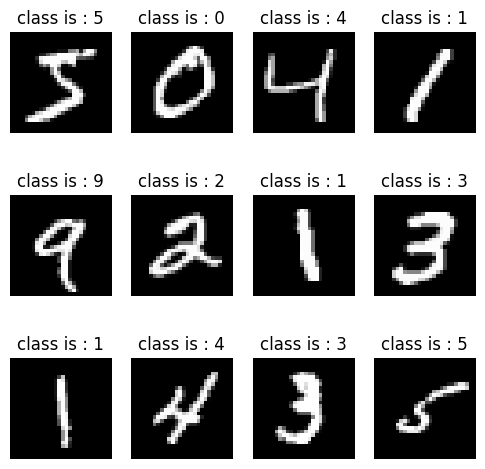

In [20]:
# merge train and validation set because later we do k fold so should be different split at each time
# and not fixed validatio dataset
X_train = np.concatenate([train_set[0], valid_set[0]])
y_train = np.concatenate([train_set[1], valid_set[1]])
X_test, y_test = test_set


fig, axes = plt.subplots(3, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title("class is : " +str(y_train[i]))
    ax.axis('off')
plt.show()

#### c) Build the final training and test sets, which should be balanced

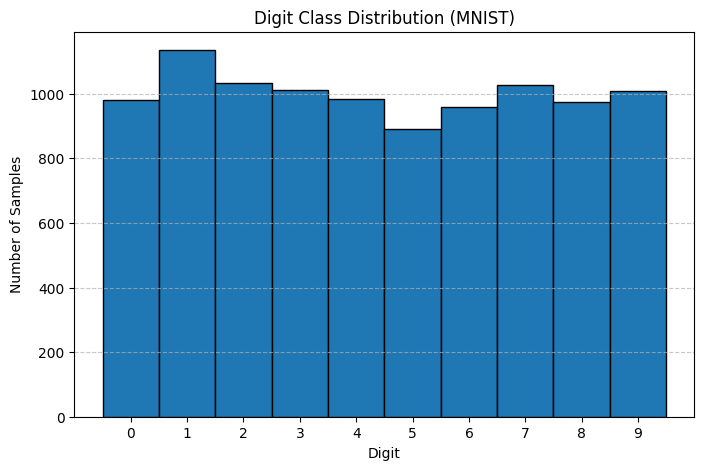

In [21]:
# verify how each class is distributed in the class
all_labels = np.concatenate([y_test])

plt.figure(figsize=(8, 5))
plt.hist(all_labels, bins=np.arange(11) - 0.5, edgecolor='black')
plt.title("Digit Class Distribution (MNIST)")
plt.xlabel("Digit")
plt.ylabel("Number of Samples")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:

# dataet is too big so function allows to choose how many
def create_balanced_subset_fixed(X, y, n_samples_per_class):

    X_ds, y_ds = [], []
    unique_labels = np.unique(y)

    for label in unique_labels:
        idx = np.where(y == label)[0]

        selected_idx = np.random.choice(idx, n_samples_per_class, replace=False)
        X_ds.append(X[selected_idx])
        y_ds.append(y[selected_idx])

    print(f" => Created balanced subset with {n_samples_per_class} samples per class having ({len(unique_labels)} classes total)")
    return np.vstack(X_ds), np.hstack(y_ds)


In [23]:
# Example: take 200 samples per class for training, 100 per class for testing
X_train_2, y_train_2 = create_balanced_subset_fixed(X_train, y_train, n_samples_per_class=275)
X_test_2,  y_test_2  = create_balanced_subset_fixed(X_test, y_test,  n_samples_per_class=100)

 => Created balanced subset with 275 samples per class having (10 classes total)
 => Created balanced subset with 100 samples per class having (10 classes total)


although we didnt use all dataset, this allowed to have faster experiments

### b. Classification of digits based on raw pixel values using SVM and different kernels

Create, train and test several SVM classifiers with different kernels (linear, polynomial, RBF, ...). For the training, perform a cross-validation using 10 folds, and test different with several $C$ and kernel parameter values (e.g. for $\gamma$ for RBF kernel) in order to get the best classifier. After the test, display the classification performances and confusion matrix of each SVM classifier (see class _metrics_).

### Linear

In [24]:
# define C values for linear training
param_grid = [0.1, 1, 10]

best_score = 0
best_C = None
best_y_pred = None

# cross-valid for each C
for param in param_grid:
    print("  => Training with C val " + str(param))
    svm = SVC(kernel='linear', C=param)
    scores = cross_val_score(svm, X_train_2, y_train_2, cv=10, scoring='accuracy')
    mean_score = scores.mean() * 100
    
    print(f"  Mean accuracy for C={param} is : {mean_score:.2f}%")

    # save if best c
    if mean_score > best_score:
        best_score = mean_score
        best_C = param
        best_y_pred = cross_val_predict(svm, X_train_2, y_train_2, cv=10)

print(f"  Best C = {best_C} with mean CV accuracy : {best_score:.2f}%\n")

  => Training with C val 0.1
  Mean accuracy for C=0.1 is : 91.09%
  => Training with C val 1
  Mean accuracy for C=1 is : 90.25%
  => Training with C val 10
  Mean accuracy for C=10 is : 90.25%
  Best C = 0.1 with mean CV accuracy : 91.09%



 Test Accuracy: 90.30%
 Test F1-score (macro): 0.9024

Classification details per class are :
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       100
           1       0.93      0.99      0.96       100
           2       0.85      0.87      0.86       100
           3       0.91      0.85      0.88       100
           4       0.90      0.96      0.93       100
           5       0.90      0.84      0.87       100
           6       0.94      0.93      0.93       100
           7       0.94      0.88      0.91       100
           8       0.87      0.86      0.86       100
           9       0.91      0.87      0.89       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



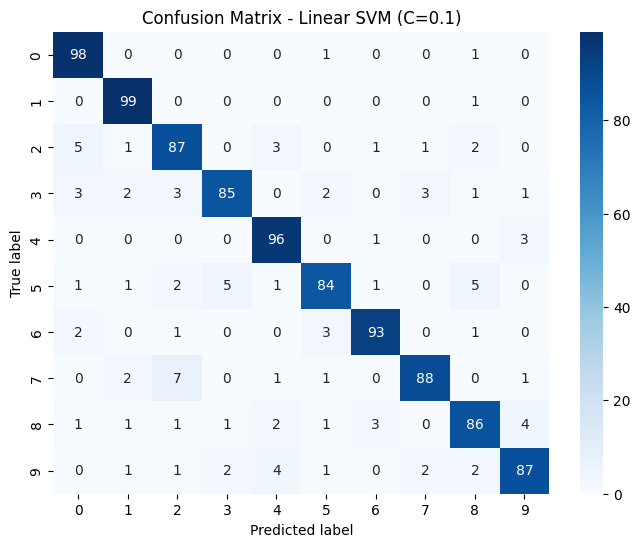

In [25]:
# Train final model with best C  allowing to test with test set
best_model = SVC(kernel='linear', C=best_C)
best_model.fit(X_train_2, y_train_2)

# Test set predictions
y_pred_test = best_model.predict(X_test_2)

# Evaluation metrics
acc = accuracy_score(y_test_2, y_pred_test)
f1 = f1_score(y_test_2, y_pred_test, average='macro')

# base metrics
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test F1-score (macro): {f1:.4f}\n")
# per class split
print("Classification details per class are :")
print(classification_report(y_test_2, y_pred_test))


cm = confusion_matrix(y_test_2, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Linear SVM (C={best_C})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Polynomial

In [26]:
# define C values and polynomial degrees for training
C_values = [0.1, 1, 10]
degrees = [2, 3, 4]

best_score = 0
best_C = None
best_degree = None
best_y_pred = None

# cross-validation for each C and degree
for C in C_values:
    for d in degrees:
        print("  => Training with C=" + str(C) + " and degree=" + str(d))
        svm = SVC(kernel='poly', C=C, degree=d)
        scores = cross_val_score(svm, X_train_2, y_train_2, cv=10, scoring='accuracy')
        mean_score = scores.mean() * 100

        print(f"  Mean accuracy for C={C}, degree={d} is : {mean_score:.2f}%")

        # save if best parameters
        if mean_score > best_score:
            best_score = mean_score
            best_C = C
            best_degree = d
            best_y_pred = cross_val_predict(svm, X_train_2, y_train_2, cv=10)

print(f"\n  Best C = {best_C}, best degree = {best_degree} with mean CV accuracy : {best_score:.2f}%\n")


  => Training with C=0.1 and degree=2
  Mean accuracy for C=0.1, degree=2 is : 87.53%
  => Training with C=0.1 and degree=3
  Mean accuracy for C=0.1, degree=3 is : 82.25%
  => Training with C=0.1 and degree=4
  Mean accuracy for C=0.1, degree=4 is : 74.07%
  => Training with C=1 and degree=2
  Mean accuracy for C=1, degree=2 is : 93.60%
  => Training with C=1 and degree=3
  Mean accuracy for C=1, degree=3 is : 91.78%
  => Training with C=1 and degree=4
  Mean accuracy for C=1, degree=4 is : 88.18%
  => Training with C=10 and degree=2
  Mean accuracy for C=10, degree=2 is : 94.04%
  => Training with C=10 and degree=3
  Mean accuracy for C=10, degree=3 is : 93.02%
  => Training with C=10 and degree=4
  Mean accuracy for C=10, degree=4 is : 90.51%

  Best C = 10, best degree = 2 with mean CV accuracy : 94.04%



 Test Accuracy: 93.20%
 Test F1-score (macro): 0.9318

Classification details per class are :
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.94      1.00      0.97       100
           2       0.89      0.93      0.91       100
           3       0.94      0.90      0.92       100
           4       0.90      0.98      0.94       100
           5       0.94      0.92      0.93       100
           6       0.99      0.95      0.97       100
           7       0.93      0.89      0.91       100
           8       0.92      0.90      0.91       100
           9       0.93      0.89      0.91       100

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



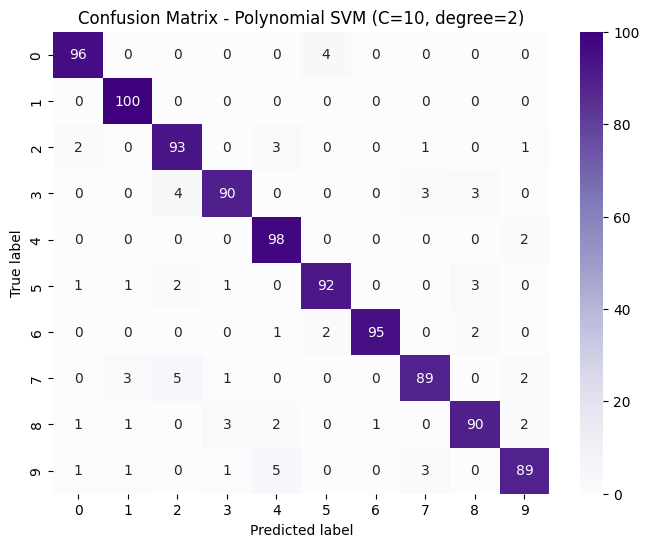

In [27]:
# Train final model with best C and degree allowing to test with test set
best_model = SVC(kernel='poly', C=best_C, degree=best_degree)
best_model.fit(X_train_2, y_train_2)

# Test set predictions
y_pred_test = best_model.predict(X_test_2)

# Evaluation metrics
acc = accuracy_score(y_test_2, y_pred_test)
f1 = f1_score(y_test_2, y_pred_test, average='macro')

# base metrics
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test F1-score (macro): {f1:.4f}\n")
# per class split
print("Classification details per class are :")
print(classification_report(y_test_2, y_pred_test))

# confusion matrix
cm = confusion_matrix(y_test_2, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title(f"Confusion Matrix - Polynomial SVM (C={best_C}, degree={best_degree})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


### RBF

In [28]:
# define C and gamma values for RBF training
C_values = [0.1, 1, 10]
gamma_values = [0.001, 0.01, 0.1]

best_score = 0
best_C = None
best_gamma = None
best_y_pred = None

# cross-validation for each C and gamma
for C in C_values:
    for g in gamma_values:
        print("  => Training with C=" + str(C) + " and gamma=" + str(g))
        svm = SVC(kernel='rbf', C=C, gamma=g)
        scores = cross_val_score(svm, X_train_2, y_train_2, cv=10, scoring='accuracy')
        mean_score = scores.mean() * 100

        print(f"  Mean accuracy for C={C}, gamma={g} is : {mean_score:.2f}%")

        # save if best parameters
        if mean_score > best_score:
            best_score = mean_score
            best_C = C
            best_gamma = g
            best_y_pred = cross_val_predict(svm, X_train_2, y_train_2, cv=10)

print(f"\n  Best C = {best_C}, best gamma = {best_gamma} with mean CV accuracy : {best_score:.2f}%\n")

  => Training with C=0.1 and gamma=0.001
  Mean accuracy for C=0.1, gamma=0.001 is : 63.45%
  => Training with C=0.1 and gamma=0.01
  Mean accuracy for C=0.1, gamma=0.01 is : 88.73%
  => Training with C=0.1 and gamma=0.1
  Mean accuracy for C=0.1, gamma=0.1 is : 28.62%
  => Training with C=1 and gamma=0.001
  Mean accuracy for C=1, gamma=0.001 is : 88.62%
  => Training with C=1 and gamma=0.01
  Mean accuracy for C=1, gamma=0.01 is : 93.45%
  => Training with C=1 and gamma=0.1
  Mean accuracy for C=1, gamma=0.1 is : 80.95%
  => Training with C=10 and gamma=0.001
  Mean accuracy for C=10, gamma=0.001 is : 91.96%
  => Training with C=10 and gamma=0.01
  Mean accuracy for C=10, gamma=0.01 is : 94.40%
  => Training with C=10 and gamma=0.1
  Mean accuracy for C=10, gamma=0.1 is : 82.55%

  Best C = 10, best gamma = 0.01 with mean CV accuracy : 94.40%



 Test Accuracy: 94.30%
 Test F1-score (macro): 0.9428

Classification details per class are :
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.97      1.00      0.99       100
           2       0.89      0.93      0.91       100
           3       0.96      0.94      0.95       100
           4       0.93      0.99      0.96       100
           5       0.95      0.94      0.94       100
           6       0.96      0.96      0.96       100
           7       0.95      0.89      0.92       100
           8       0.92      0.91      0.91       100
           9       0.94      0.89      0.91       100

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



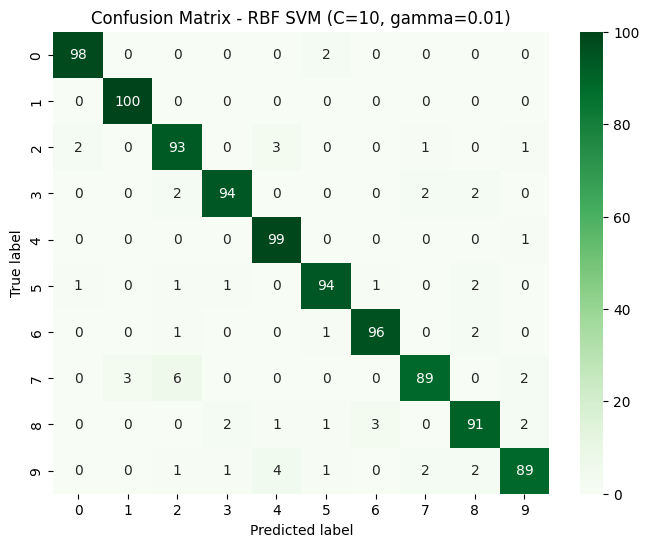

In [29]:
# Train final model with best C and gamma allowing to test with test set
best_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_model.fit(X_train_2, y_train_2)

# Test set predictions
y_pred_test = best_model.predict(X_test_2)

# Evaluation metrics
acc = accuracy_score(y_test_2, y_pred_test)
f1 = f1_score(y_test_2, y_pred_test, average='macro')

# base metrics
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test F1-score (macro): {f1:.4f}\n")
# per class split
print("Classification details per class are :")
print(classification_report(y_test_2, y_pred_test))

# confusion matrix
cm = confusion_matrix(y_test_2, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - RBF SVM (C={best_C}, gamma={best_gamma})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### c. (Optional) Impact of preprocessing and feature extraction

Analyse the impact of the classification performances using the following preprocessing and feature extraction steps:

#### a) Preprocessing step: convert images to binary (i.e. black and white) representations 

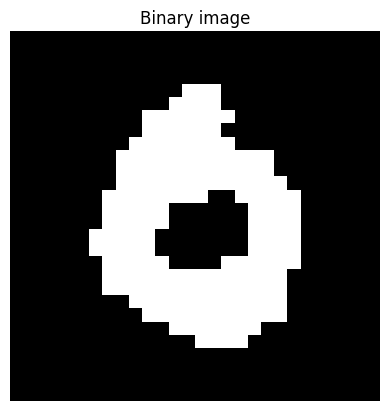

In [30]:
threshold = 0.5
X_train_bin = (X_train_2 > threshold).astype(int)
X_test_bin = (X_test_2 > threshold).astype(int)

plt.imshow(X_train_bin[0].reshape((28, 28)), cmap="gray")
plt.title("Binary image")
plt.axis("off")
plt.show()

 Test Accuracy: 93.50%
 Test F1-score (macro): 0.9347

Classification details per class are :
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      1.00      0.98       100
           2       0.90      0.91      0.91       100
           3       0.95      0.93      0.94       100
           4       0.91      0.98      0.94       100
           5       0.93      0.89      0.91       100
           6       0.98      0.98      0.98       100
           7       0.94      0.89      0.91       100
           8       0.91      0.90      0.90       100
           9       0.93      0.91      0.92       100

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.93      1000



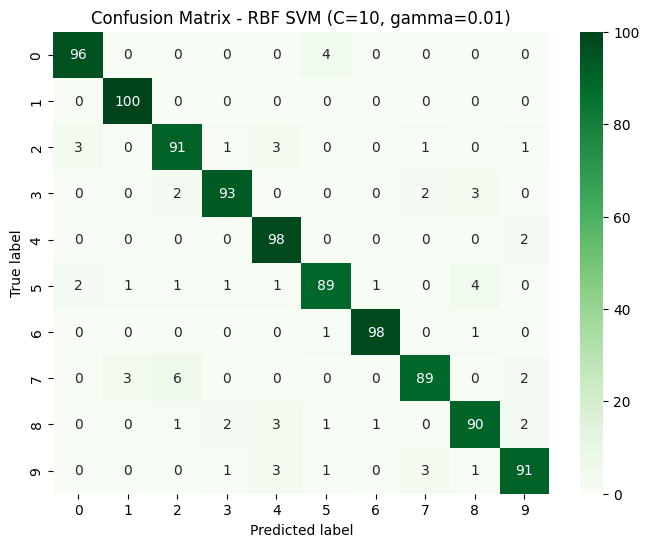

In [31]:
# Train final model with best C and gamma allowing to test with test set
best_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_model.fit(X_train_bin, y_train_2)

# Test set predictions
y_pred_test = best_model.predict(X_test_bin)

# Evaluation metrics
acc = accuracy_score(y_test_2, y_pred_test)
f1 = f1_score(y_test_2, y_pred_test, average='macro')

# base metrics
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test F1-score (macro): {f1:.4f}\n")
# per class split
print("Classification details per class are :")
print(classification_report(y_test_2, y_pred_test))

# confusion matrix
cm = confusion_matrix(y_test_2, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - RBF SVM (C={best_C}, gamma={best_gamma})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Results do no change much from best model (slight decrease in metrics). But 

#### b) Feature extraction steps:
* Horizontal and vertical projections (i.e. compute the sum of grey pixel values along the the X and Y-axis)
* Local binary patterns
* Any other usable image features that you may have found

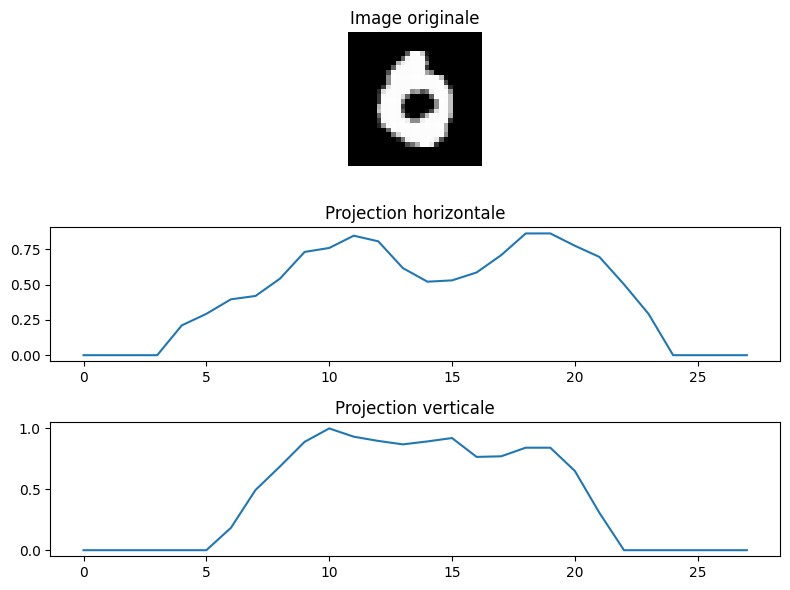

In [32]:

def compute_projections(X, img_h=28, img_w=28, normalize=True):
    """
    X: (n_samples, 784) en float ou int
    Retourne: (n_samples, 56) = 28 (horizontal) + 28 (vertical)
    """
    X_reshaped = X.reshape(-1, img_h, img_w)
    horizontal = np.sum(X_reshaped, axis=2)  # somme sur colonnes -> 28
    vertical   = np.sum(X_reshaped, axis=1)  # somme sur lignes  -> 28
    feats = np.concatenate([horizontal, vertical], axis=1)

    if normalize:
        # normalisation par max pour rendre comparable quel que soit le contraste
        max_val = np.max(feats, axis=1, keepdims=True)
        max_val[max_val == 0] = 1.0
        feats = feats / max_val
    return feats

# Choisis la version d’images que tu veux (grises ou binaires)
X_train_proj = compute_projections(X_train_2)     # ou compute_projections(X_train_bin)
X_test_proj  = compute_projections(X_test_2)      # ou compute_projections(X_test_bin)

# Visualisation rapide comme dans ton snippet (ex sur le 1er exemple du train "brut")
example_image = X_train_2[0].reshape((28, 28))
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.imshow(example_image, cmap="gray")
plt.title("Image originale")
plt.axis("off")

# horizontal 
plt.subplot(3, 1, 2)
plt.plot(X_train_proj[0][:28])
plt.title("Projection horizontale")

# vertical 
plt.subplot(3, 1, 3)
plt.plot(X_train_proj[0][28:])
plt.title("Projection verticale")
plt.tight_layout()
plt.show()


* Local binary patterns


(2750, 10) (1000, 10)


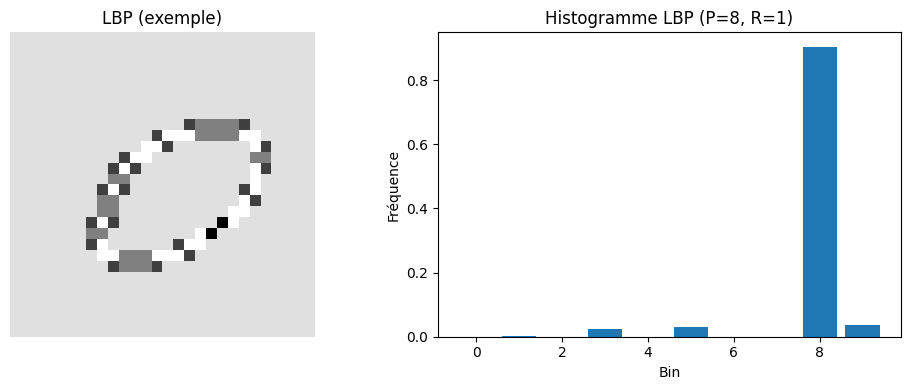

In [40]:
from skimage.feature import local_binary_pattern 

radius = 1
P = 8 * radius
method = "uniform"

def lbp_features(X):
    """X: (n, 784) ou (n, 28, 28) → retourne (n, P+2)"""
    X = X.reshape(-1, 28, 28)
    feats = []
    for img in X:
        lbp = local_binary_pattern(img, P=P, R=radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(P+3), range=(0, P+2), density=True)
        feats.append(hist)
    return np.vstack(feats)

# prends les binaires si dispo, sinon les gris
Xtr = X_train_bin if 'X_train_bin' in globals() else X_train_2
Xte = X_test_bin  if 'X_test_bin'  in globals() else X_test_2

lbp_train = lbp_features(Xtr)
lbp_test  = lbp_features(Xte)
print(lbp_train.shape, lbp_test.shape)  # (n_train, P+2) (n_test, P+2)

# petite visu
i = 3
img = Xtr[i].reshape(28, 28)
lbp_img = local_binary_pattern(img, P=P, R=radius, method=method)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(lbp_img, cmap="gray"); plt.title("LBP (exemple)"); plt.axis("off")
plt.subplot(1,2,2); plt.bar(range(P+2), lbp_train[i]); plt.title(f"Histogramme LBP (P={P}, R={radius})")
plt.xlabel("Bin"); plt.ylabel("Fréquence"); plt.tight_layout(); plt.show()

### d. Analysis of the results

Analyse the results obtained with the best SVM classifier.

a) Which kernel and parameters were used?

Although not too far from the polynomial kernel, the best results were proposed with RBF :

 - Test Accuracy: 95.30%
 - Test F1-score (macro): 0.9529

The RBF kernel performed best, we think it can model more complex, non-linear relationships between pixels, which better fits the curved decision boundaries in data such as this dataset

With the parameters :   Best C = 10, best gamma = 0.01 with mean CV accuracy : 94.29% on the validation sets

Indeed, higher C values (like 10) gave better results for all models, showing that allowing the model to fit the data more closely helped performance.

The chosen gamma value of 0.01 is stable => not too small to underfit and not too large to overfit. This combination gave gave a good balance between flexibility and generalization.

 



b) Which digit classes are the best/worse recognized against which? Why?

Although the results obtained were not bad, the classes which presented more difficult with the best model were :

- 9 : often confused with 4
- 8 : often confused with 5


Handwritten 4 and 9 may be similar in some cases, so the model may have struggled a bit for recognizing these. The same thing with 5, which may be be similar in some cases, depending on the person's handwritting styles.


For the best : 
- 0 
- 1
- 6
- 7

Presented the best results, with accuracies => than 0.95 amongst the 100 samples used for each class.

c) What is the impact of the sizes of the training and test sets on the classification performance?

We first used a strategy where the number of training and test samples matched the smallest class distribution, but this took too long (about 4500 for training and 850 for testing).
 
We then reduced the dataset size, which still gave very good results with our best model (275 per class train and 100 for testing)
 
The dataset size must be adequate to ensure that the model generalizes well and can recognize all digit classes correctly. Larger datasets improve the model’s ability to learn complex relations and make better predictions on unseen data because the more handwriting styles the model sees, the better it can generalize, since writing styles vary between individuals. 

In the end, we doubled the training size (from 275 to 550 samples per class) for the linear model to observe the effect and saw a small improvement, from 92.10% to 92.30% in accuracy and from 0.9208 to 0.9228 in F1-score. This suggests that increasing training size helps, and more complex models like RBF would likely benefit even more.